In [1]:
!protoc --python_out=. --proto_path=../proto/ message.proto

In [2]:
import message_pb2
import pandas as pd
import requests
import time

def parse_snoop(data):
	position = 0
	length_field = 0
	while position < len(data):
		length_field = data[position]
		position += 1
		if position + length_field > len(data):
			print("bah!")
			return
		encoded = data[position:position+length_field]
		position += length_field
		s = message_pb2.SnoopData()
		s.ParseFromString(encoded)
		yield s


In [10]:
#host="192.168.158.113"
host="192.168.50.116"
duration_ms=1000
r = requests.get(f"http://{host}/start_snoop?duration_ms={duration_ms}", {})
print(r.text)
time.sleep(duration_ms/1000+0.1)
r = requests.get(f"http://{host}/get_snoop", {})
print(len(r.content))

Snoop started. will run for 1000 buffer available: 51200
6025


In [11]:
#f = open("snoop.bin", "rb")
#cont = f.read()
#f = open("snoop2.bin", "wb")
#f.write(r.content)
#f.close()
d=[]
#for s in parse_snoop(cont):
for s in parse_snoop(r.content):
	d.append({"prop": s.message.prop, "value":s.message.value, "src": s.metadata.source, "ts":s.metadata.recv_us})
df = pd.DataFrame(d)
df

,prop,value,src,ts
0,396832,b':',4,29787937
1,396832,b'\x00\x04\x01\x04\x01',4,29788370
2,396832,b'J\x00%\x00',4,29788417
3,396832,b'\x02FF\x00',4,29797910
4,396832,b'\x01',4,29798076
...,...,...,...,...
301,396832,b'\x01',4,30728064
302,396832,b'\xfe\xff\x06',4,30728218
303,396832,b'\x00',4,30737910
304,396832,b'\x05\x0c/9\x01\x02T',4,30738063


In [6]:
f = open("snoop2.bin", "rb")
cont = f.read()
f.close()
d=[]
for s in parse_snoop(cont):
	d.append({"prop": s.message.prop, "value":s.message.value, "src": s.metadata.source, "ts":s.metadata.recv_us})
df = pd.DataFrame(d)

ts0 = df[0:1].ts[0]
df['ts'] -= ts0
df['ts'] /= 1000

df=df.set_index(df.ts)

In [242]:
print((df[df.src==1].prop.unique()))
print((df[df.src==2].prop.unique()))
df[(df.src==2) & (df.prop>2000)].value

[452984876]
[]


Series([], Name: value, dtype: object)

In [ ]:
df.style.format(formatter={"prop": "0x{:04x}", "value": lambda v: "".join("%02x, " % b for b in v[:-1])+"%02x"%v[-1]})

In [55]:
def print_to_c(df):
	"""Formats a C struct definition."""
	delay = -1
	for row in df.iterrows():
		f = row[1]
		if delay == -1:
			delay = f['ts']
			pd = 'XX'  # fill in the delay between end of cycle and start of the next one.
		else:
			pd = '%2d' % int(round(f['ts']-delay))
		print(f"{{ .prop = {'0x%04x' % f['prop']}, .send_delay_ms = {pd}, .val = {{ .size = {len(f['value'])}, .bytes = {{ {''.join('0x%02x, ' % b for b in f['value'])}}} }} }},")
		delay = f['ts']
print_to_c(df[(df.ts>80) & (df.ts<140) & (df.src==1)])
#print_to_c()

{ .prop = 0x052a, .send_delay_ms = XX, .val = { .size = 1, .bytes = { 0x3a, } } },
{ .prop = 0x0532, .send_delay_ms =  0, .val = { .size = 5, .bytes = { 0x00, 0x04, 0x01, 0x04, 0x01, } } },
{ .prop = 0x053c, .send_delay_ms =  0, .val = { .size = 4, .bytes = { 0x4a, 0x00, 0x25, 0x00, } } },
{ .prop = 0x0528, .send_delay_ms = 10, .val = { .size = 4, .bytes = { 0x02, 0x46, 0x46, 0x00, } } },
{ .prop = 0x0530, .send_delay_ms =  0, .val = { .size = 1, .bytes = { 0x01, } } },
{ .prop = 0x053b, .send_delay_ms =  0, .val = { .size = 6, .bytes = { 0x02, 0x24, 0xa4, 0x00, 0x20, 0x00, } } },
{ .prop = 0x0527, .send_delay_ms = 10, .val = { .size = 6, .bytes = { 0x46, 0x46, 0x46, 0x1e, 0x1e, 0x46, } } },
{ .prop = 0x052e, .send_delay_ms =  0, .val = { .size = 1, .bytes = { 0x75, } } },
{ .prop = 0x053a, .send_delay_ms =  0, .val = { .size = 6, .bytes = { 0x16, 0x11, 0x09, 0x38, 0x19, 0x11, } } },
{ .prop = 0x0524, .send_delay_ms = 10, .val = { .size = 1, .bytes = { 0x70, } } },
{ .prop = 0x052d, .s

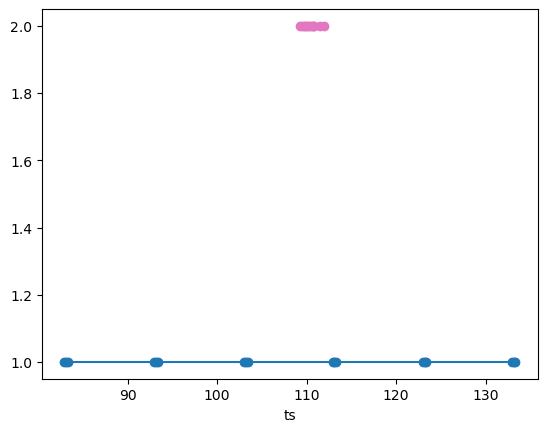

In [66]:
# plot by source and separate the extended ids
df = df.set_index(df.ts)
#df = df[df.ts<1000]
# First response from 1
#print("first message from 1:\n", df[(df.ts>0) & (df.ts<30) & (df.src==1)])

#print("message groups from 1:\n", df[(df.ts>80) & (df.ts<140) & (df.src==1)])

#df = df[(df.ts>0) & (df.ts<412) & (df.src==2)]
def plot_by_src(df):
	for src in [1,2]:
		df[(df.src==src) & (df.prop < 2000)].src.plot(marker='o')
		df[(df.src==src) & (df.prop > 2000)].src.plot(marker='o')
burst_from_1 = df[(df.ts>80) & (df.ts<180) & (df.src==1)]
#print_to_c(burst_from_1)
plot_by_src(burst_from_1)

plot_by_src(df[(df.ts>100) & (df.ts<125) & (df.src==2)])
#print_to_c(df[(df.ts>100) & (df.ts<125) & (df.src==2)])

In [100]:
df[df.src==1].describe()

,prop,src,ts
count,7.130000e+02,713.0,7.130000e+02
mean,1.270774e+07,1.0,1.981629e+06
std,7.484784e+07,0.0,1.113417e+06
min,1.313000e+03,1.0,2.347700e+04
25%,1.320000e+03,1.0,1.013277e+06
50%,1.328000e+03,1.0,1.993160e+06
75%,1.335000e+03,1.0,2.932986e+06
max,4.529849e+08,1.0,3.903489e+06


<AxesSubplot:ylabel='car'>

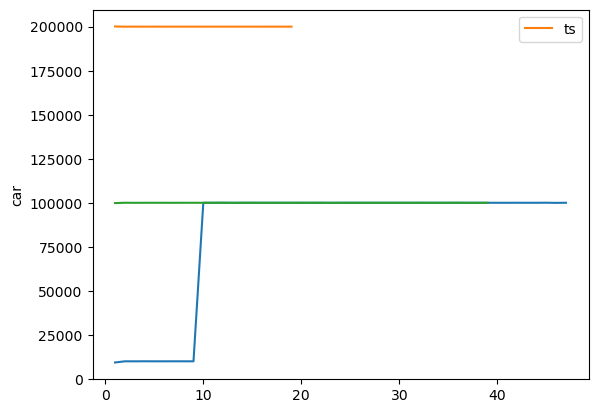

In [77]:
df[df.src==1][:1]
#df[:40]
df[df.prop==452984902].reset_index().ts.diff().plot()
ax=df[df.prop==452984876].reset_index().ts.diff().plot(legend=True, ylabel="car")
df[df.prop==1318].reset_index().ts.diff().plot()